In [1]:
from typing import Tuple, Iterable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from tqdm.notebook import tqdm

CONTROLLER_ADDR = '192.168.0.104'

df_X = pd.read_csv('X_test.csv', header=None)

In [2]:
def predict(x: Iterable) -> Tuple[float, float, float, float]:
    resp = requests.get(f'http://{CONTROLLER_ADDR}/predict', params={
        f'x{idx + 1}': xi
        for idx, xi in enumerate(x)
    })
    resp.raise_for_status()

    # noinspection PyTypeChecker
    return tuple(float(y) for idx, y in enumerate(str(resp.text).split(' ')) if idx < 4)


predict((-0.52109855, -0.57133687, -0.481523, -0.5882358, -0.80570453, -0.03607523,
         -0.8392386, -0.8549552, 0.3732829, -0.5899839, 0.38921237, 0.5864193,
         1.0258859, -0.41387412, -0.5701152, -0.6521362, -0.8420634, -0.68346435,
         -0.8151803, -0.668313, 0.6052867, 1.0809759, 0.77627265, -0.77486044,))

(0.0, 0.05, 0.95, 0.0)

In [3]:
y_pred = np.array([
    predict(x)
    for _, x in tqdm(df_X.iterrows(), total=len(df_X))
])

  0%|          | 0/33 [00:00<?, ?it/s]

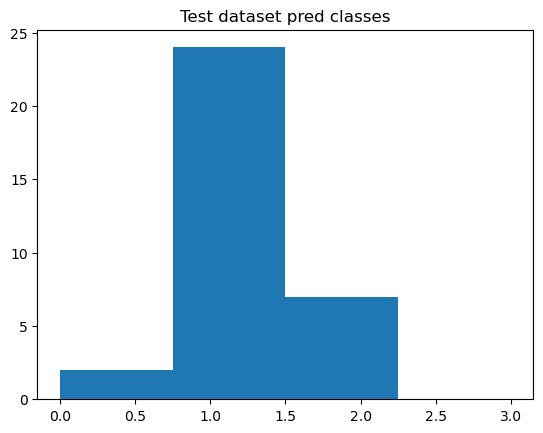

In [6]:
y_pred_cls = np.argmax(y_pred, axis=-1)
plt.title("Test dataset pred classes")
plt.hist(y_pred_cls, bins=4, range=(0, 3))
plt.show()